# Modelo 3: Red Neuronal Híbrida (Word2Vec + Dense)

Este notebook implementa una arquitectura de **Red Neuronal de dos ramas** utilizando Keras (TensorFlow).

**Estrategia:**
1. **Rama de Texto:** Utiliza vectores pre-entrenados de **Word2Vec** (Google News, 300 dims) promediados por tweet.
2. **Rama Numérica:** Procesa las *meta-features* (Mean Encoding, One-Hot Encoding, conteos) normalizadas.
3. **Concatenación:** Ambas ramas se unen para la clasificación final.

## Imports

In [ ]:
# Standard
import pandas as pd
import numpy as np
import pathlib
import matplotlib.pyplot as plt
import seaborn as sns
import warnings

# Deep Learning (Keras/TensorFlow) - Must be imported before sklearn to avoid warnings
import tensorflow as tf
from keras import models, callbacks, optimizers, Input
from keras.layers import Dense, Dropout, Concatenate, BatchNormalization
from keras.utils import set_random_seed

# Scikit-Learn
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.metrics import f1_score, roc_curve, auc, confusion_matrix, accuracy_score, precision_score, recall_score
from sklearn.inspection import permutation_importance
from sklearn.base import BaseEstimator

# Word2Vec (Gensim)
import gensim.downloader as api

# NLP (Spacy para tokenización y limpieza)
import spacy
from spacy.cli import download
try:
    nlp = spacy.load("en_core_web_sm")
except OSError:
    download("en_core_web_sm")
    nlp = spacy.load("en_core_web_sm")

warnings.filterwarnings('ignore')

## Constantes

In [2]:
COLOR_NO_DISASTER = '#3498db'
COLOR_DISASTER = '#e74c3c'
COLOR_GENERAL = '#95a5a6'

SEED = 42
set_random_seed(SEED)
np.random.seed(SEED)

WORD2VEC_DIM = 300

In [3]:
# Cargar Word2Vec pre-entrenado
word2vec_model = api.load('word2vec-google-news-300')

## Datos

In [4]:
data_path = pathlib.Path("../.data/raw")
df = pd.read_csv(data_path / "train.csv")
test_df = pd.read_csv(data_path / "test.csv")

print(f'Shape Train: {df.shape}')
print(f'Shape Test: {test_df.shape}')

Shape Train: (7613, 5)
Shape Test: (3263, 4)


## Feature Engineering

In [5]:
def preprocess_text(df):
    df = df.copy()
    
    # Tokenización y limpieza con Spacy (sin lematización para mejor match con Word2Vec)
    def clean_tokenize(text):
        doc = nlp(str(text).lower())
        tokens = [token.text for token in doc if token.is_alpha and not token.is_stop and len(token.text) > 2]
        return tokens
    
    df['tokens'] = df['text'].apply(clean_tokenize)
    
    # Features básicas
    df['word_count'] = df['text'].str.split().str.len()
    df['char_count'] = df['text'].str.len()
    df['hashtag_count'] = df['text'].str.count(r'#')
    df['mention_count'] = df['text'].str.count(r'@')
    df['url_count'] = df['text'].str.count(r'http')
    
    # Keyword Cleaning
    df['keyword'] = df['keyword'].fillna('unknown')
    
    # Location cleaning (binaria)
    df['has_location'] = df['location'].notna().astype(int)
    
    return df

df = preprocess_text(df)
test_df = preprocess_text(test_df)

# Convertir tweets a vectores Word2Vec (promedio de palabras)
def text_to_w2v_vector(tokens, model, dim=300):
    vectors = []
    for token in tokens:
        try:
            vectors.append(model[token])
        except KeyError:
            continue
    
    if len(vectors) > 0:
        return np.mean(vectors, axis=0)
    else:
        return np.zeros(dim)

train_w2v_vectors = np.array([text_to_w2v_vector(tokens, word2vec_model, WORD2VEC_DIM) 
                               for tokens in df['tokens']])

test_w2v_vectors = np.array([text_to_w2v_vector(tokens, word2vec_model, WORD2VEC_DIM) 
                              for tokens in test_df['tokens']])

print(f"Word2Vec vectors generados: Train {train_w2v_vectors.shape}, Test {test_w2v_vectors.shape}")

Word2Vec vectors generados: Train (7613, 300), Test (3263, 300)


## Split y Mean Encoding

In [6]:
# Split Train/Validation
X = df.drop(columns=['target'])
y = df['target'].values

X_train_raw, X_val_raw, y_train, y_val, train_w2v, val_w2v = train_test_split(
    X, y, train_w2v_vectors, test_size=0.2, random_state=SEED, stratify=y
)

print(f"Train shape: {X_train_raw.shape}, Val shape: {X_val_raw.shape}")

# --- 1. Mean Encoding (Keyword) ---
keyword_means = X_train_raw.assign(target=y_train).groupby('keyword')['target'].mean()
global_mean = y_train.mean()

X_train_raw['keyword_encoded'] = X_train_raw['keyword'].map(keyword_means).fillna(global_mean)
X_val_raw['keyword_encoded'] = X_val_raw['keyword'].map(keyword_means).fillna(global_mean)
test_df['keyword_encoded'] = test_df['keyword'].map(keyword_means).fillna(global_mean)

# --- 2. One Hot Encoding (Top Keywords) ---
top_k = 20
top_keywords = X_train_raw['keyword'].value_counts().head(top_k).index

def apply_ohe_keyword(series, top_keys):
    return series.apply(lambda x: x if x in top_keys else 'other')

ohe = OneHotEncoder(sparse_output=False, handle_unknown='ignore')

train_kw_top = apply_ohe_keyword(X_train_raw['keyword'], top_keywords).values.reshape(-1, 1)
val_kw_top = apply_ohe_keyword(X_val_raw['keyword'], top_keywords).values.reshape(-1, 1)
test_kw_top = apply_ohe_keyword(test_df['keyword'], top_keywords).values.reshape(-1, 1)

X_train_ohe = ohe.fit_transform(train_kw_top)
X_val_ohe = ohe.transform(val_kw_top)
X_test_ohe = ohe.transform(test_kw_top)

# --- 3. Numerical Scaling (StandardScaler) ---
num_cols = ['word_count', 'char_count', 'hashtag_count', 'mention_count', 'url_count', 'keyword_encoded', 'has_location']
scaler = StandardScaler()

X_train_num = scaler.fit_transform(X_train_raw[num_cols])
X_val_num = scaler.transform(X_val_raw[num_cols])
X_test_num_scaled = scaler.transform(test_df[num_cols])

# Concatenar features numéricas + OHE
X_train_meta = np.hstack([X_train_num, X_train_ohe])
X_val_meta = np.hstack([X_val_num, X_val_ohe])
X_test_meta = np.hstack([X_test_num_scaled, X_test_ohe])

print(f"Meta Features Shape: {X_train_meta.shape}")
print(f"Word2Vec Features Shape: {train_w2v.shape}")

Train shape: (6090, 11), Val shape: (1523, 11)
Meta Features Shape: (6090, 28)
Word2Vec Features Shape: (6090, 300)


## Modelo

Model: "functional_4"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ w2v_input           │ (None, 300)       │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_20 (Dense)    │ (None, 128)       │     38,528 │ w2v_input[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ meta_input          │ (None, 28)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_20          │ (None, 128)       │          0 │ dense_20[0][0]    │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_22 (Dense)    │ (None, 32)        │        928 │ meta_input[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_21 (Dense)    │ (None, 64)        │      8,256 │ dropout_20[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 32)        │        128 │ dense_22[0][0]    │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_21          │ (None, 64)        │          0 │ dense_21[0][0]    │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_22          │ (None, 32)        │          0 │ batch_normalizat… │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_4       │ (None, 96)        │          0 │ dropout_21[0][0], │
│ (Concatenate)       │                   │            │ dropout_22[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_23 (Dense)    │ (None, 64)        │      6,208 │ concatenate_4[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_23          │ (None, 64)        │          0 │ dense_23[0][0]    │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_24 (Dense)    │ (None, 32)        │      2,080 │ dropout_23[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_24          │ (None, 32)        │          0 │ dense_24[0][0]    │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ output (Dense)      │ (None, 1)         │         33 │ dropout_24[0][0]  │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 56,161 (219.38 KB)

 Trainable params: 56,097 (219.13 KB)

 Non-trainable params: 64 (256.00 B)

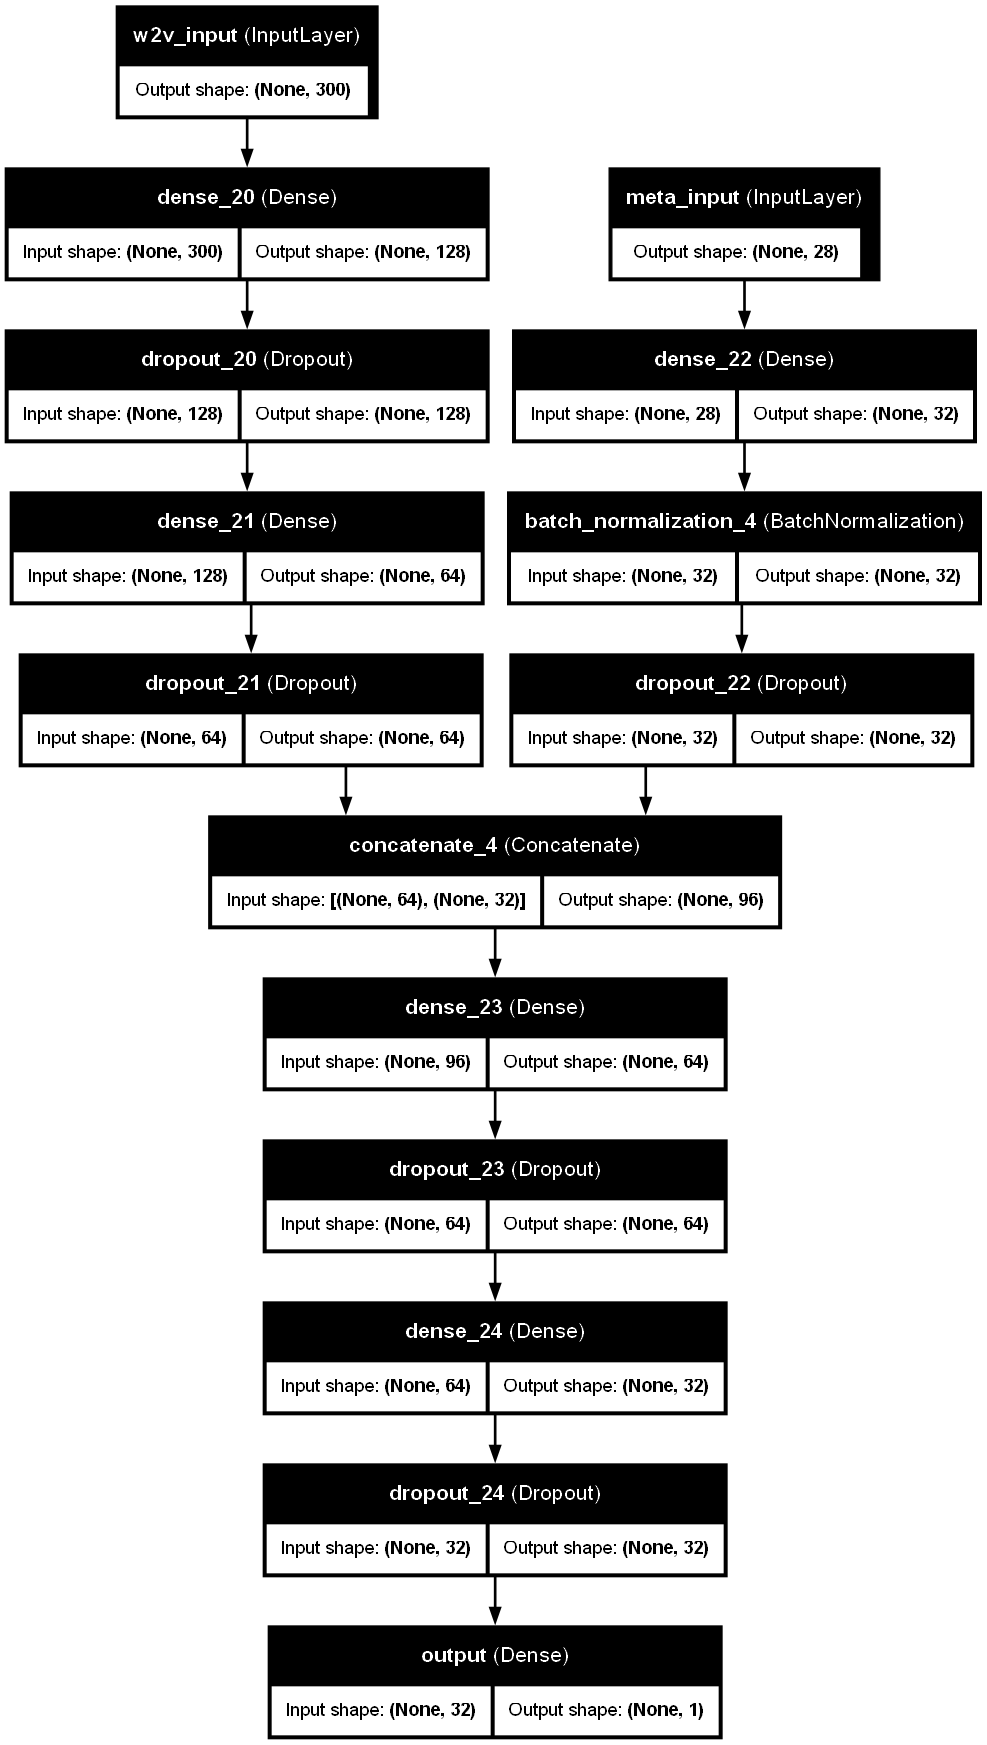

In [ ]:
def build_w2v_model(w2v_dim, meta_dim):
    # --- Rama Word2Vec ---
    w2v_input = Input(shape=(w2v_dim,), name='w2v_input')
    x = Dense(128, activation='relu')(w2v_input)
    x = Dropout(0.5)(x)
    x = Dense(64, activation='relu')(x)
    x = Dropout(0.5)(x)
    
    # --- Rama Meta ---
    meta_input = Input(shape=(meta_dim,), name='meta_input')
    y = Dense(32, activation='relu')(meta_input)
    y = BatchNormalization()(y)
    y = Dropout(0.5)(y)
    
    # --- Concatenación ---
    concat = Concatenate()([x, y])
    z = Dense(64, activation='relu')(concat)
    z = Dropout(0.5)(z)
    z = Dense(32, activation='relu')(z)
    z = Dropout(0.3)(z)
    output = Dense(1, activation='sigmoid', name='output')(z)
    
    model = models.Model(inputs=[w2v_input, meta_input], outputs=output)
    
    model.compile(
        optimizer=optimizers.Adam(learning_rate=0.001),
        loss='binary_crossentropy',
        metrics=['AUC']
    )
    return model

model = build_w2v_model(w2v_dim=WORD2VEC_DIM, meta_dim=X_train_meta.shape[1])
model.summary()

tf.keras.utils.plot_model(
    model, 
    to_file='neural_network_architecture.png',
    show_shapes=True,
    show_layer_names=True,
    rankdir='TB',
    expand_nested=True,
    dpi=96
)

## Entrenamiento

Epoch 1/50
191/191 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8987 - loss: 0.3878 - val_AUC: 0.8950 - val_loss: 0.3973 - learning_rate: 2.5000e-04
Epoch 2/50
191/191 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8987 - loss: 0.3878 - val_AUC: 0.8950 - val_loss: 0.3973 - learning_rate: 2.5000e-04
Epoch 2/50
191/191 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.9033 - loss: 0.3782 - val_AUC: 0.8949 - val_loss: 0.3966 - learning_rate: 2.5000e-04
Epoch 3/50
191/191 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.9033 - loss: 0.3782 - val_AUC: 0.8949 - val_loss: 0.3966 - learning_rate: 2.5000e-04
Epoch 3/50
191/191 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - AUC: 0.9007 - loss: 0.3806 - val_AUC: 0.8949 - val_loss: 0.3946 - learning_rate: 2.5000e-04
Epoch 4/50
191/191 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - AUC: 0.9007 - loss: 0.3806 - val_AUC: 0.8949 - val_loss: 0.3946 - learning_rate: 2.5000e-04
Epoch 4/50
191/191 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - AUC: 0.9073 - loss: 0.3675 - val_AUC: 0.8947 - val_loss: 0.3960 - lear

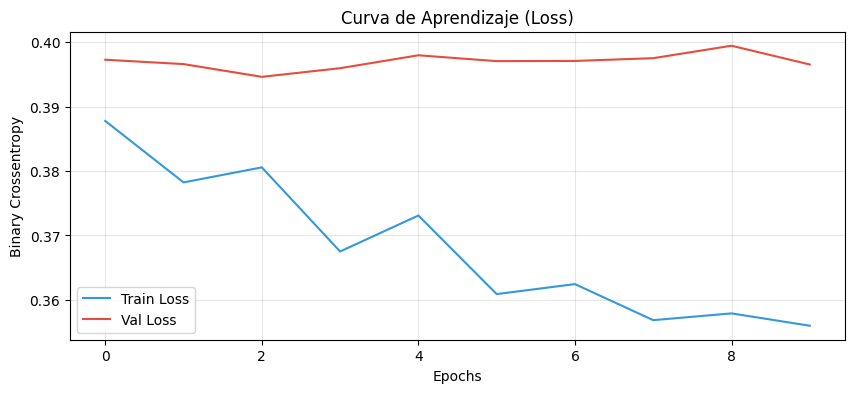

In [11]:
early_stopping = callbacks.EarlyStopping(
    monitor='val_loss',
    patience=7,
    restore_best_weights=True,
    verbose=1
)

reduce_lr = callbacks.ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,
    patience=3,
    min_lr=1e-6,
    verbose=1
)

history = model.fit(
    x={'w2v_input': train_w2v, 'meta_input': X_train_meta},
    y=y_train,
    validation_data=({'w2v_input': val_w2v, 'meta_input': X_val_meta}, y_val),
    epochs=50,
    batch_size=32,
    callbacks=[early_stopping, reduce_lr],
    verbose=1
)

# Plot Loss
plt.figure(figsize=(10, 4))
plt.plot(history.history['loss'], label='Train Loss', color=COLOR_NO_DISASTER)
plt.plot(history.history['val_loss'], label='Val Loss', color=COLOR_DISASTER)
plt.title('Curva de Aprendizaje (Loss)')
plt.xlabel('Epochs')
plt.ylabel('Binary Crossentropy')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

## Análisis Final


Mejor Threshold: 0.400
Mejor F1 Score (Validación): 0.8024
Accuracy: 0.8293
Precision: 0.7976
Recall: 0.8073


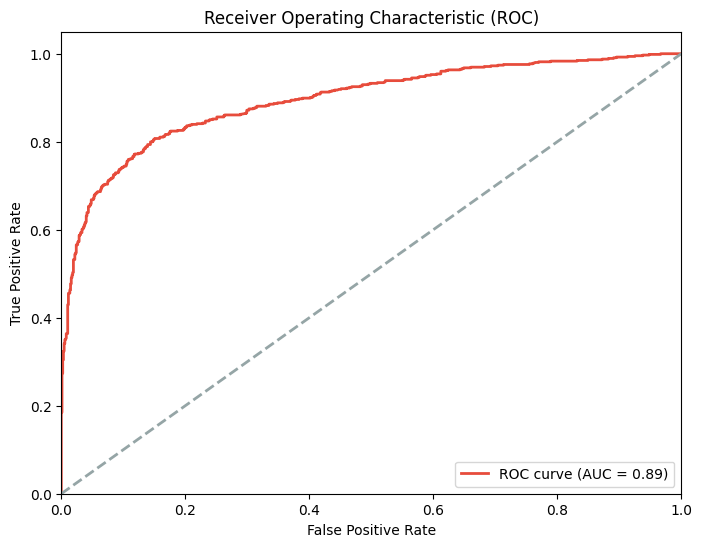

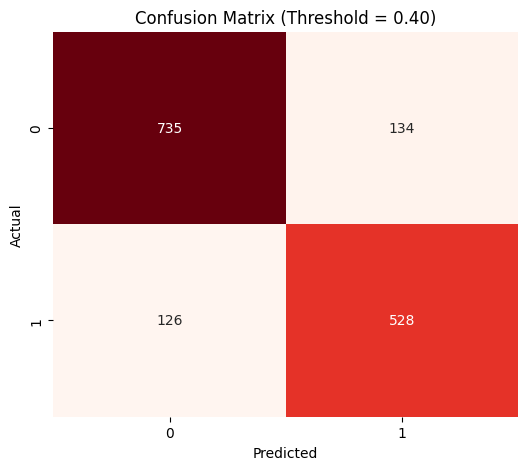

In [ ]:
# Predicciones (Probabilidades)
y_val_probs = model.predict({'w2v_input': val_w2v, 'meta_input': X_val_meta}, verbose=0).flatten()

# 1. Optimizar Threshold para F1
best_thresh = 0.5
best_f1 = 0
for thresh in np.arange(0.1, 0.9, 0.01):
    preds = (y_val_probs > thresh).astype(int)
    score = f1_score(y_val, preds)
    if score > best_f1:
        best_f1 = score
        best_thresh = thresh

print(f"\nMejor Threshold: {best_thresh:.3f}")
print(f"Mejor F1 Score (Validación): {best_f1:.4f}")

# Métricas adicionales
y_val_pred = (y_val_probs > best_thresh).astype(int)
print(f"Accuracy: {accuracy_score(y_val, y_val_pred):.4f}")
print(f"Precision: {precision_score(y_val, y_val_pred):.4f}")
print(f"Recall: {recall_score(y_val, y_val_pred):.4f}")

# 2. Curva ROC
fpr, tpr, _ = roc_curve(y_val, y_val_probs)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color=COLOR_DISASTER, lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color=COLOR_GENERAL, lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.title('Receiver Operating Characteristic (ROC)')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc="lower right")
plt.show()

# 3. Matriz de Confusión
cm = confusion_matrix(y_val, y_val_pred)

plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Reds', cbar=False)
plt.title(f'Confusion Matrix (Threshold = {best_thresh:.2f})')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

# 4. Feature Importance (Meta Features con Permutation Importance)
class KerasMetaWrapper(BaseEstimator):
    def __init__(self, model, text_data, threshold=0.5):
        self.model = model
        self.text_data = text_data
        self.threshold = threshold
    
    def fit(self, X, y=None):
        return self
    
    def predict(self, X_meta):
        probs = self.model.predict({'w2v_input': self.text_data, 'meta_input': X_meta}, verbose=0)
        return (probs > self.threshold).astype(int).flatten()
    
    def score(self, X_meta, y):
        return f1_score(y, self.predict(X_meta))

# Subset para acelerar
subset_idx = np.random.choice(len(X_val_meta), 500, replace=False)
wrapper = KerasMetaWrapper(model, val_w2v[subset_idx], threshold=best_thresh)

results = permutation_importance(wrapper, X_val_meta[subset_idx], y_val[subset_idx], 
                                   scoring='f1', n_repeats=5, random_state=SEED)

# Nombres de features
feat_names = num_cols + list(ohe.get_feature_names_out(['keyword']))

# Top 10
sorted_idx = results.importances_mean.argsort()[::-1][:10]
plt.figure(figsize=(10, 6))
sns.barplot(x=results.importances_mean[sorted_idx], y=np.array(feat_names)[sorted_idx], color=COLOR_DISASTER)
plt.title("Permutation Feature Importance (Meta Features)")
plt.xlabel("Decrease in F1 Score")
plt.show()

## Submission

In [10]:
# Predecir Test
y_test_probs = model.predict({'w2v_input': test_w2v_vectors, 'meta_input': X_test_meta}, verbose=0).flatten()
y_test_pred = (y_test_probs > best_thresh).astype(int)

# Guardar
submission = pd.DataFrame({'id': test_df['id'], 'target': y_test_pred})
submission_path = pathlib.Path("../.data/submission")
submission_path.mkdir(parents=True, exist_ok=True)
submission.to_csv(submission_path / "neural_network_submission.csv", index=False)

print(f"\n✓ Submission guardada en {submission_path / 'neural_network_submission.csv'}")
print(f"Predicciones positivas (desastre): {y_test_pred.sum()} / {len(y_test_pred)}")


✓ Submission guardada en ..\.data\submission\neural_network_submission.csv
Predicciones positivas (desastre): 1396 / 3263
